# 1. Install and import pip and kfp

In [ ]:
!python -m pip install --user --upgrade pip

In [ ]:
!pip3 install kfp --upgrade --user

**Please restart your notebook before you proceed.**

In [ ]:
import kfp
from kfp import dsl

## 2. Build a lightweight component from a python function

       a.  Define the python function with all its dependencies installed and imported within it
       b.  Download your data
       c.  Write your function and return its output

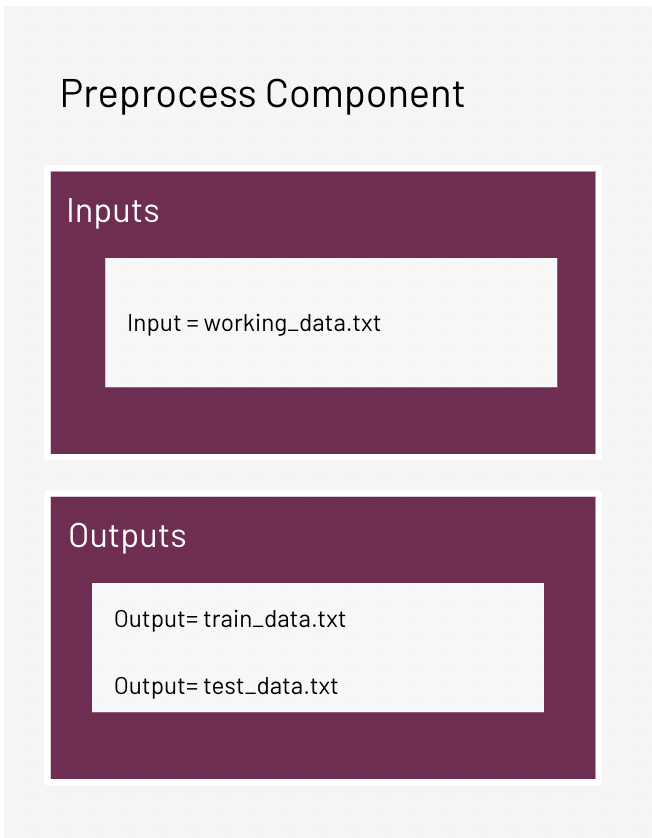

In [ ]:
def preprocess(data_path,train_data,test_data):
    # install libraries 
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install','scikit-learn==0.22'])
    subprocess.run([sys.executable, '-m', 'pip', 'install','pandas==0.23.4'])
    # import libraries
    import pickle
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler 

    #download the data
    data = pd.read_csv("https://raw.githubusercontent.com/MavenCode/KubeflowTraining/master/Data/Churn_Modelling.csv")

    #dropping some columns that are not needed
    data = data.drop(columns=['RowNumber','CustomerId','Surname'], axis=1)
    #data features
    X = data.iloc[:,:-1]
    #target data
    y = data.iloc[:,-1:]   
    #encoding the categorical columns
    le = LabelEncoder()
    ohe = OneHotEncoder()
    X['Gender'] = le.fit_transform(X['Gender'])
    geo_df = pd.DataFrame(ohe.fit_transform(X[['Geography']]).toarray())

    #getting feature name after onehotencoding
    geo_df.columns = ohe.get_feature_names(['Geography'])

    #merging geo_df with the main data
    X = X.join(geo_df) 
    #dropping the old columns after encoding
    X.drop(columns=['Geography'], axis=1, inplace=True)

    #splitting the data 
    X_train,X_test,y_train,y_test = train_test_split( X,y, test_size=0.2, random_state = 42)
    #feature scaling
    sc =StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    #saving the values from the dataframe
    y_train = y_train.values
    y_test = y_test.values
    
    #Save the train_data as a pickle file to be used by the train component.
    with open(f'{data_path}/{train_data}', 'wb') as f:
        pickle.dump((X_train,  y_train), f)
        
    #Save the test_data as a pickle file to be used by the predict component.
    with open(f'{data_path}/{test_data}', 'wb') as f:
        pickle.dump((X_test,  y_test), f)
    
    return(print('Done!'))

### Convert your funtion into a lightweight component

In [ ]:
preprocess_op = kfp.components.create_component_from_func(preprocess,base_image="python:3.7.1")

Now, we have the preprocess_op as a kubeflow pipeline component.

## 3. Buiding a Reusable component from a python script

    
    a. Write your python function in a .py script
    b. Build and push your docker image
    c. Build a resuable component with your image and script
    
**NOTE: The python script and docker image below, are not executed in this notebook.**

### a. Python script named "reusable_preprocess.py"

In [ ]:
#importing libraries
def preprocess():
    #importing libraries
    import joblib
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler 
    
    #importing the data
    data = pd.read_csv("https://raw.githubusercontent.com/MavenCode/KubeflowTraining/master/Data/Churn_Modelling.csv")
    #dropping some columns that are not needed
    data = data.drop(columns=['RowNumber','CustomerId','Surname'], axis=1)
    #data features
    X = data.iloc[:,:-1]
    #target data
    y = data.iloc[:,-1:]   
    #encoding the categorical columns
    le = LabelEncoder()
    ohe = OneHotEncoder()
    X['Gender'] = le.fit_transform(X['Gender'])
    geo_df = pd.DataFrame(ohe.fit_transform(X[['Geography']]).toarray())

    #getting feature name after onehotencoding
    geo_df.columns = ohe.get_feature_names(['Geography'])

    #merging geo_df with the main data
    X = X.join(geo_df) 
    #dropping the old columns after encoding
    X.drop(columns=['Geography'], axis=1, inplace=True)

    #splitting the data 
    X_train,X_test,y_train,y_test = train_test_split( X,y, test_size=0.2, random_state = 42)
    #feature scaling
    sc =StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    #saving output file to path
    np.save('X_train.npy', X_train)
    np.save('X_test.npy', X_test)
    np.save('y_train.npy', y_train)
    np.save('y_test.npy', y_test)

#defining and parsing arguments
if __name__ == '__main__':
    preprocess()


### b. Dockerfile
**This Docker image was pushed to dockerhub with the steps detailed in the slides**

In [ ]:
FROM python:3.7.1
WORKDIR /preprocess_data
RUN pip install --upgrade pip \
&& pip install -U scikit-learn numpy pandas
COPY preprocess.py /preprocess_data
ENTRYPOINT ["python", "preprocess.py"]

**Define your python function as a kubeflow component  using the Kubeflow Pipelines DSL . The DSL defines your pipeline’s interactions with the component’s Docker container.** 

In [ ]:
def preprocess_op(data):
    return dsl.ContainerOp(
        name = 'Preprocess Data',
        # docker image
        image = 'mavencodev/preprocess-component:v.0.2',
        arguments = [],
        # component outputs
        file_outputs={
            'X_train': '/preprocess_data/X_train.npy',
            'X_test': '/preprocess_data/X_test.npy',
            'y_train': '/preprocess_data/y_train.npy',
            'y_test': '/preprocess_data/y_test.npy'     
        }
    )
# exporting the component as a yaml file
if __name__ == "__main__":
    kfp.components.create_component_from_func(
    preprocess_op, #function name
    output_component_file="preprocess-reusable.yaml") ,
    base_image="python:3.7.1",
    packages_to_install = ["pandas==0.23.4", "scikit-learn==0.22"]

### 4.  Create a yaml file from a lightweight component

You can also create a yaml file with a lightweight component. 

In [ ]:
def preprocess(data_path,train_data,test_data):
    import pickle
    # import Library
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install','scikit-learn==0.22'])
    subprocess.run([sys.executable, '-m', 'pip', 'install','pandas==0.23.4'])
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler 

    #importing the data
    data = pd.read_csv("https://raw.githubusercontent.com/MavenCode/KubeflowTraining/master/Data/Churn_Modelling.csv")

    #dropping some columns that are not needed
    data = data.drop(columns=['RowNumber','CustomerId','Surname'], axis=1)
    #data features
    X = data.iloc[:,:-1]
    #target data
    y = data.iloc[:,-1:]   
    #encoding the categorical columns
    le = LabelEncoder()
    ohe = OneHotEncoder()
    X['Gender'] = le.fit_transform(X['Gender'])
    geo_df = pd.DataFrame(ohe.fit_transform(X[['Geography']]).toarray())

    #getting feature name after onehotencoding
    geo_df.columns = ohe.get_feature_names(['Geography'])

    #merging geo_df with the main data
    X = X.join(geo_df) 
    #dropping the old columns after encoding
    X.drop(columns=['Geography'], axis=1, inplace=True)

    #splitting the data 
    X_train,X_test,y_train,y_test = train_test_split( X,y, test_size=0.2, random_state = 42)
    #feature scaling
    sc =StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    #saving the values from the dataframe
    y_train = y_train.values
    y_test = y_test.values
    
    #Save the train_data as a pickle file to be used by the train component.
    with open(f'{data_path}/{train_data}', 'wb') as f:
        pickle.dump((X_train,  y_train), f)
        
    #Save the test_data as a pickle file to be used by the predict component.
    with open(f'{data_path}/{test_data}', 'wb') as f:
        pickle.dump((X_test,  y_test), f)
    
    return(print('Done!'))

#exporting function to YAML file
if __name__ == "__main__":
    kfp.components.create_component_from_func(
    preprocess, #function name
    output_component_file="preprocess-component.yaml") ,
    base_image="python:3.7.1",
    packages_to_install = ["pandas==0.23.4", "scikit-learn==0.22"]

The YAML file is created in the working directory of the notebook except if it is specified otherwise

#### Here is what the yaml file looks like

In [ ]:
name: Preprocess
inputs:
- {name: data_path}
- {name: train_data}
- {name: test_data}
implementation:
  container:
    image: python:3.7
    command:
    - sh
    - -ec
    - |
      program_path=$(mktemp)
      printf "%s" "$0" > "$program_path"
      python3 -u "$program_path" "$@"
    - "def preprocess(data_path,train_data,test_data):\n    import pickle\n    # import\
      \ Library\n    import sys, subprocess;\n    subprocess.run([sys.executable,\
      \ '-m', 'pip', 'install','scikit-learn==0.22'])\n    subprocess.run([sys.executable,\
      \ '-m', 'pip', 'install','pandas==0.23.4'])\n    import pandas as pd\n    import\
      \ numpy as np\n    from sklearn.preprocessing import LabelEncoder\n    from\
      \ sklearn.preprocessing import OneHotEncoder\n    from sklearn.model_selection\
      \ import train_test_split\n    from sklearn.preprocessing import StandardScaler\
      \ \n\n    #importing the data\n    data = pd.read_csv(\"https://raw.githubusercontent.com/MavenCode/KubeflowTraining/master/Data/Churn_Modelling.csv\"\
      )\n\n    #dropping some columns that are not needed\n    data = data.drop(columns=['RowNumber','CustomerId','Surname'],\
      \ axis=1)\n    #data features\n    X = data.iloc[:,:-1]\n    #target data\n\
      \    y = data.iloc[:,-1:]   \n    #encoding the categorical columns\n    le\
      \ = LabelEncoder()\n    ohe = OneHotEncoder()\n    X['Gender'] = le.fit_transform(X['Gender'])\n\
      \    geo_df = pd.DataFrame(ohe.fit_transform(X[['Geography']]).toarray())\n\n\
      \    #getting feature name after onehotencoding\n    geo_df.columns = ohe.get_feature_names(['Geography'])\n\
      \n    #merging geo_df with the main data\n    X = X.join(geo_df) \n    #dropping\
      \ the old columns after encoding\n    X.drop(columns=['Geography'], axis=1,\
      \ inplace=True)\n\n    #splitting the data \n    X_train,X_test,y_train,y_test\
      \ = train_test_split( X,y, test_size=0.2, random_state = 42)\n    #feature scaling\n\
      \    sc =StandardScaler()\n    X_train = sc.fit_transform(X_train)\n    X_test\
      \ = sc.transform(X_test)\n    #saving the values from the dataframe\n    y_train\
      \ = y_train.values\n    y_test = y_test.values\n\n    #Save the train_data as\
      \ a pickle file to be used by the train component.\n    with open(f'{data_path}/{train_data}',\
      \ 'wb') as f:\n        pickle.dump((X_train,  y_train), f)\n\n    #Save the\
      \ test_data as a pickle file to be used by the predict component.\n    with\
      \ open(f'{data_path}/{test_data}', 'wb') as f:\n        pickle.dump((X_test,\
      \  y_test), f)\n\n    return(print('Done!'))\n\nimport argparse\n_parser = argparse.ArgumentParser(prog='Preprocess',\
      \ description='')\n_parser.add_argument(\"--data-path\", dest=\"data_path\"\
      , type=str, required=True, default=argparse.SUPPRESS)\n_parser.add_argument(\"\
      --train-data\", dest=\"train_data\", type=str, required=True, default=argparse.SUPPRESS)\n\
      _parser.add_argument(\"--test-data\", dest=\"test_data\", type=str, required=True,\
      \ default=argparse.SUPPRESS)\n_parsed_args = vars(_parser.parse_args())\n\n\
      _outputs = preprocess(**_parsed_args)\n"
    args:
    - --data-path
    - {inputValue: data_path}
    - --train-data
    - {inputValue: train_data}
    - --test-data
    - {inputValue: test_data}



##### kfp.components.load_component_from_file or kfp.components.load_component_from_url  can be used to load the yaml file in the pipeline

In [ ]:
kfp.components.load_component_from_file("preprocess-component.yaml")

<function Preprocess(data_path, train_data, test_data)>

### The yaml life above can be defined even better by calling the python script this way:

This can only be built manually.

**PS: DO NOT RUN**

In [ ]:
# Name your component
name:  preprocessing
description:  transforms the data into the best form for training.
#define your inputs, outputs and their types
inputs:
- {name: data_path,  type: }

outputs:
- {name: output_train_data, type: }
- {name: output_test_data, type: }

implementation:
  container:
    # docker image
    image: mavencodev/preprocess-component:v.0.2
    command: [
      # python script   
      python3, /KubeflowTraining/Day 2/KubeflowComponentsAndPipeline/Labs/1_creatingPipelineComponents/reusable_componet.py,
      # define your outputs
      --input_path,             {inputValue: input_data_path},
      --output_dir,             {inputValue: output_train_data},
      --output_dir,             {inputValue: output_test_data}
      
    ]

This yaml would be pushed to you github repository and called in when compiling your pipeline using `kfp.components.load_component_from_file("https://raw.githubusercontent.com/MavenCode....yaml")`